# NatComp Cookhouse

## Intro

* **Date**: 11/30/2020
* **What**: I'm not even really sure yet.  Basically I just want a form of network where the winner naturally rises to the top, instead of me having to find the argmax of a bunch of rows of an array.  This all came up because I was about to implement multi CompSpec, and I realized how computationally complex it is going to be.  I want something more natural, where I don't have to do a bunch of computations to calculate an output.
* **Why**: I'm trying to make my networks as efficient as possible.  And an $O(n^2)$ algorithm ain't cheap in a network with a fuckton of neurons.
* **Hopes**: I hope I can find an architecture that naturally brings the winners to the top, and puts the losers on the bottom.  * **Limitations**: I don't really know what I'm doing, and everything I've tried along this avenue has failed so far.  Go team!

## Analysis Dialog

I'm just going to try a bunch of shit, and see what works.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time, sleep
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [37]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:L].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

<IPython.core.display.Javascript object>


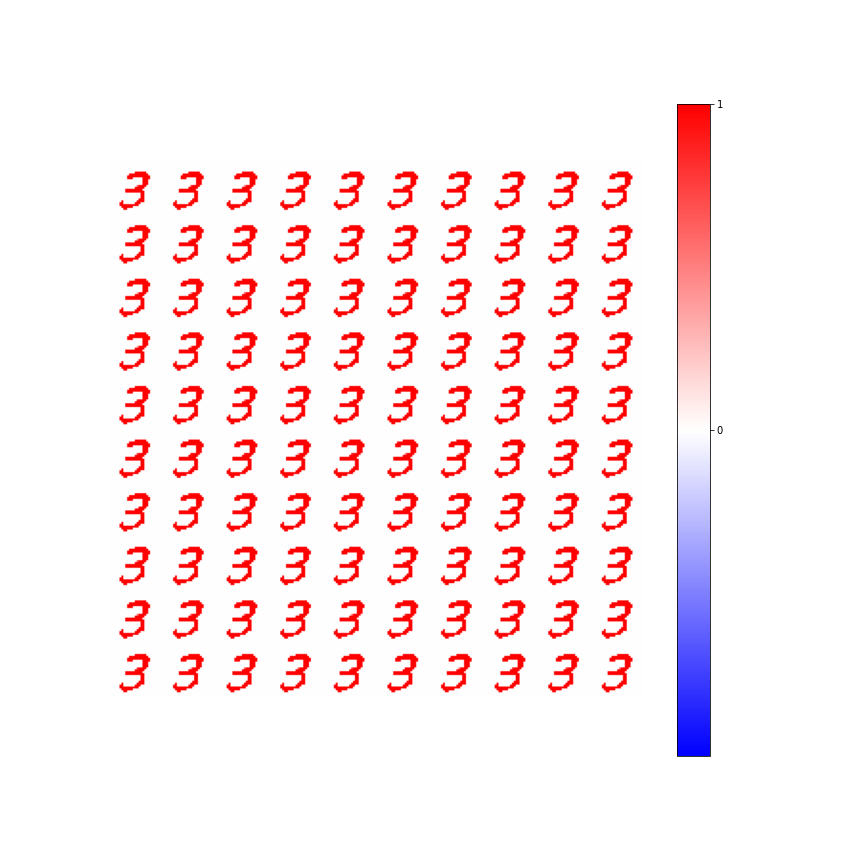

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


<IPython.core.display.Javascript object>


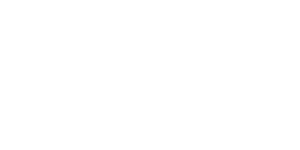

In [44]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.1

zeta = 0.001

cycles = 10000

N = Kx * Ky

w = np.random.uniform(0.01 * w_max, 0.99 * w_max, (N, L))

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

v = flat_x[7].reshape(1, -1)

for cy in range(cycles):
    p1 = np.tanh((w @ v.T) / 70)
    
#     print(p1)
        
    v_0 = p1 * np.exp(-1 * zeta * (c_i @ p1))
    
    w += xi * (w_max - w) * w * (v - v_0) * v_0
    
    if cy % 1000 == 0:
        print(cy)
        draw_weights(w, 10, 10)

AAAHAHAHAHAHAHAHAHAHAHAAHAHAHHAHH!!!! FUUUUCCCCKKK THIS!  I fucking hate Natural Competition.  Fuck THIS

## Conclusions
Natural Competition is the worst and I hate it.

## Next steps
Maybe (keyword, *Maybe*) I'll look into this again.  Bye.

12/1/2020:

This is unprecedented.  I'm restarting an experiment.  Basically, I had another idea about how this could work, and I got to try it out.  

<IPython.core.display.Javascript object>


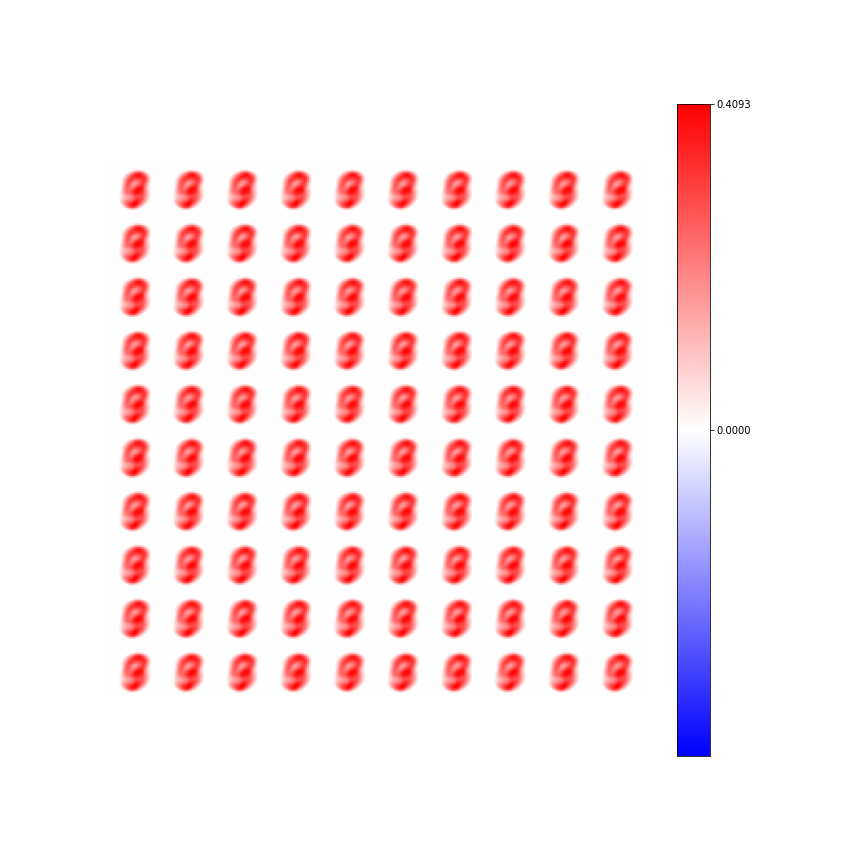

In [13]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.01

zeta = 0.1

T_s = 60000

N = Kx * Ky

w = np.random.uniform(0, 1, (N, L))

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

for i in range(T_s):
    v = flat_x[i].reshape(1, -1)
    
    o = np.tanh(w @ v.T)
    
    c = np.tanh((c_i @ o) / 1000)
    
    w += w * (1 - w) * (v - w - c) * 0.5 * xi
    
    if i % 1000 == 0:
        draw_weights(w, 10, 10)

Well, I hate that.  I need to try something else.

<IPython.core.display.Javascript object>


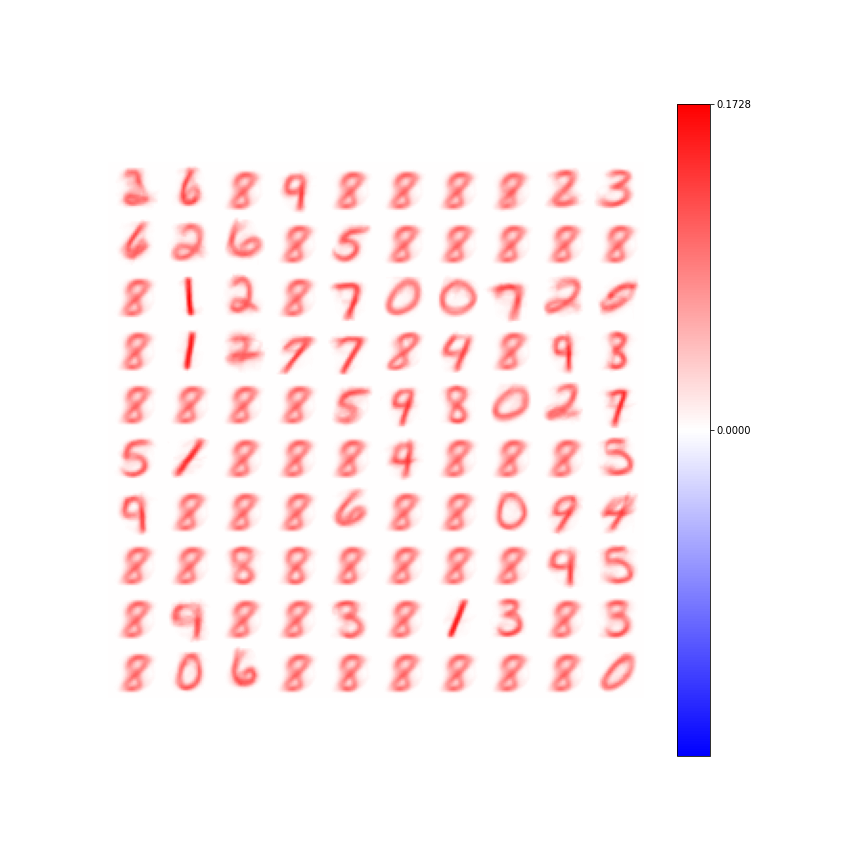

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:45<00:00, 1314.69it/s]


In [3]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.01

min_z = 0.001

zeta = 0.1

T_s = 60000

N = Kx * Ky

w = np.abs(np.random.normal(0, 1, (N, L)))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

for i in tqdm(range(T_s)):    
    
    v = flat_x[i].reshape(1, -1)
    
    w_v = w @ v.T
    
    o = w_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v))
    
    maximus = ((1 - min_z) * (np.tanh(20 * (o - np.max(c_i * o, axis=0).reshape(-1, 1))) + 1) / 2) + min_z
    
    
    w += maximus * (v - (w_v * w)) * xi
    
    if i % 10000 == 0 and i != 0:
        draw_weights(w, 10, 10)
        
        

That's certainly encouraging.  I thought that I this had better performance, but maybe I just have to change min_z.  I'm going to batch this bad boi now.  

<IPython.core.display.Javascript object>


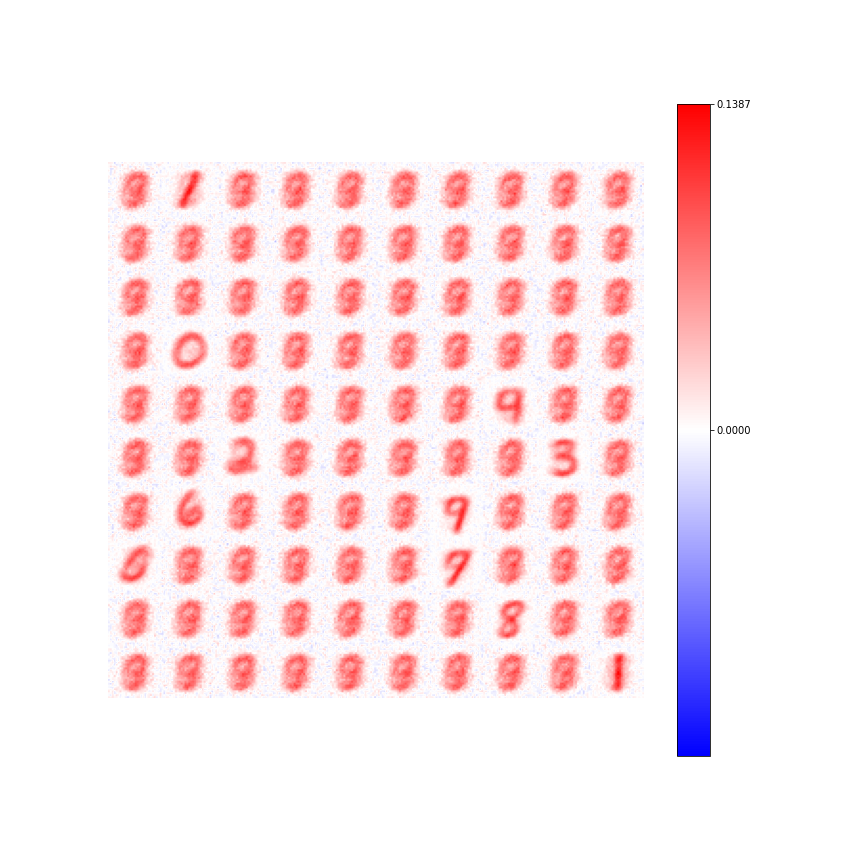

100%|██████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 414.38it/s]


In [15]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.01
n = 10

N = Kx * Ky


Nep = 30
B = 100
prec = 1e-30

T_s = 60000



w = np.abs(np.random.normal(0, 1, (N, L)))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

for ep in range(Nep):

    inputs = flat_x[np.random.permutation(T_s)]
    
    for i in tqdm(range(T_s // B)):    

        v = inputs[i * B: (i + 1) * B]

        w_v = w @ v.T

        o = w_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v))
        
        win_val = np.max(o, axis=0).reshape(1, -1)
        
        moder = (1 - win_val) ** n
        
#         print(moder)
        
        win_mask = np.zeros(o.shape)
        
        win_mask[np.argmax(o, axis=0), np.arange(o.shape[1])] = 1 - moder
        
#         win_mask = np.where(win_val == o, 1 - moder, 0)
        
#         mask = np.where(win_val == o, 1, 0)
#         print(win_mask, win_mask[:, 0])
        
        maximus = win_mask + (moder * o)
        
        del_syn = (maximus @ v) - (np.sum(w_v * maximus, axis=1).reshape(-1, 1) * w)
        
        max_del = np.max(del_syn)
        
        if max_del < prec:
            max_del = prec
#         maximus = ((1 - min_z) * (np.tanh(20 * (o - np.max(c_i * o, axis=0).reshape(-1, 1))) + 1) / 2) + min_z


        w += (xi * del_syn) / max_del
        w += np.random.uniform(-0.005, 0.005, w.shape)

    draw_weights(w, Kx, Ky)

This number of fuzzy threes makes me nervous, but I don't think there's much to be done about it.  Before I try Hebbian learning, I'm going to try KH's algo, but with a small boost for all the losers.

<IPython.core.display.Javascript object>


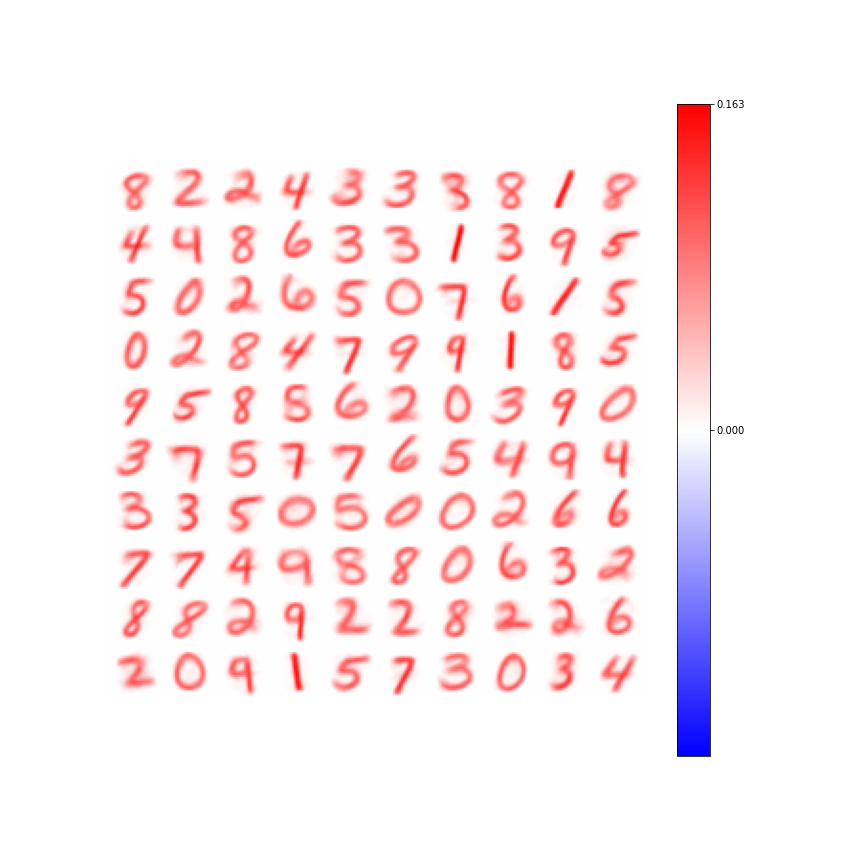

100%|██████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 598.56it/s]


0


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 606.55it/s]


1


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 637.37it/s]


2


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 632.23it/s]


3


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 634.78it/s]


4


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 630.20it/s]


5


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 633.16it/s]


6


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 630.40it/s]


7


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 632.17it/s]


8


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 639.04it/s]


9


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 633.07it/s]


10


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 634.28it/s]


11


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 632.24it/s]


12


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 618.85it/s]


13


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 628.22it/s]


14


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 624.51it/s]


15


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 636.90it/s]


16


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 628.37it/s]


17


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 625.91it/s]


18


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 623.80it/s]


19


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 617.68it/s]


20


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 614.23it/s]


21


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 614.42it/s]


22


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 618.16it/s]


23


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 614.98it/s]


24


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 611.46it/s]


25


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 615.11it/s]


26


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 610.85it/s]


27


100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 605.45it/s]


28


100%|██████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 599.85it/s]


29


In [29]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.01
n = 10

min_update = .001

N = Kx * Ky


Nep = 30
B = 100
prec = 1e-30

T_s = 60000



w = np.abs(np.random.normal(0, 1, (N, L)))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

for ep in range(Nep):

    inputs = flat_x[np.random.permutation(T_s)]
    
    for i in tqdm(range(T_s // B)):    

        v = inputs[i * B: (i + 1) * B]

        w_v = w @ v.T

        o = w_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v))
        
        maximus = np.full(o.shape, min_update)
        
        maximus[np.argmax(o, axis=0), np.arange(o.shape[1])] = 1
        
        del_syn = (maximus @ v) - (np.sum(w_v * maximus, axis=1).reshape(-1, 1) * w)
        
        max_del = np.max(del_syn)
        
        if max_del < prec:
            max_del = prec

        w += (xi * del_syn) / max_del

    draw_weights(w, Kx, Ky)
    print(ep)

<IPython.core.display.Javascript object>


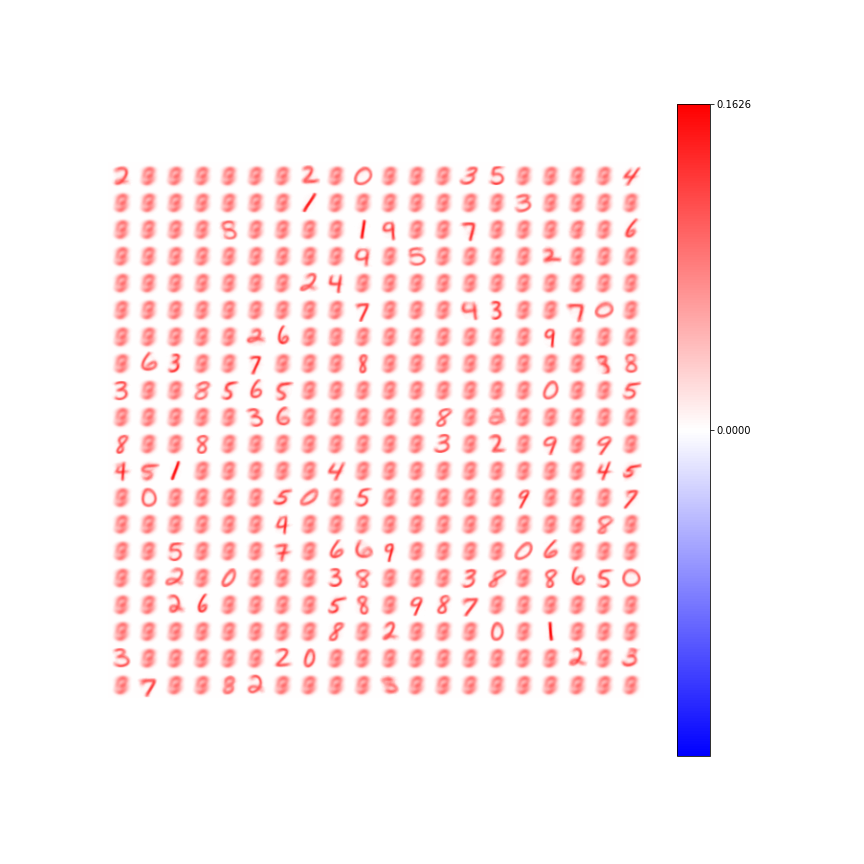

100%|███████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 62.43it/s]


In [31]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.01
n = 10

min_update = .001

N = Kx * Ky


Nep = 30
B = 400
prec = 1e-30

T_s = 60000



w = np.abs(np.random.normal(0, 1, (N, L)))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

c_i = np.ones((N, N))
np.fill_diagonal(c_i, 0)

for ep in range(Nep):

    inputs = flat_x[np.random.permutation(T_s)]
    
    for i in tqdm(range(T_s // B)):    

        v = inputs[i * B: (i + 1) * B]

        w_v = w @ v.T

        o = w_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v))
        
        maximus = np.full(o.shape, min_update)
        
        maximus[np.argmax(o, axis=0), np.arange(o.shape[1])] = 1
        
        del_syn = (maximus @ v) - (np.sum(w_v * maximus, axis=1).reshape(-1, 1) * w)
        
        max_del = np.max(del_syn)
        
        if max_del < prec:
            max_del = prec

        w += (xi * del_syn) / max_del

    draw_weights(w, Kx, Ky)


Hmm.  Ok.  CompSpec is much better.  That's a fact, jack.  Time for Hebbian learning.

<IPython.core.display.Javascript object>


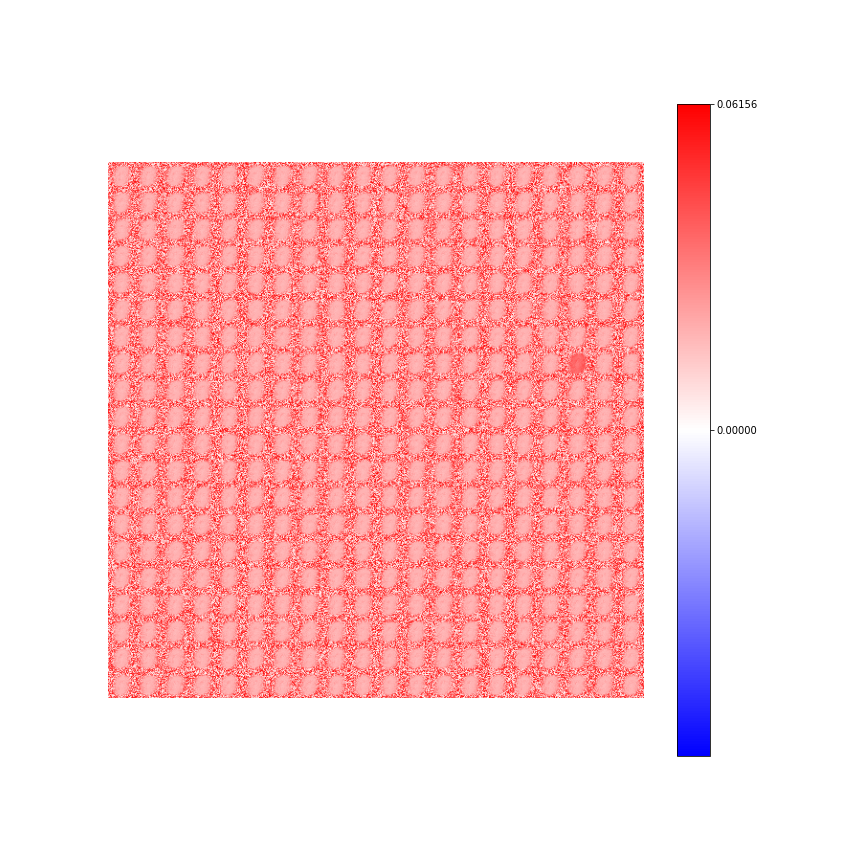

  1%|▊                                                            | 746/60000 [00:34<42:14, 23.38it/s]

KeyboardInterrupt: 

In [5]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.01
n = 1

alpha = 1
beta = 1
gamma = 1

min_update = .001

N = Kx * Ky


Nep = 1
B = 400
prec = 1e-30

T_s = 60000

w_max = 1
w_min = 0.01

w = np.abs(np.random.uniform(w_min, w_max, (N, L)))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

inputs = flat_x[np.random.permutation(T_s)]

for ep in range(Nep):
    
    for i in tqdm(range(T_s)): 
        
        v = inputs[i].reshape(1, -1)
        
        p = np.tanh(2 * (w @ v.T) / L)
        
        m_ap = np.argmax(p)
        m_p = p[m_ap]
        mod = (1 - m_p) ** n
        
        v_o = (mod * p).reshape(-1, 1)
        v_o[m_ap] += 1 - mod
        
        olp = np.minimum(v_o, v)
        ns = np.maximum(v_o - v, 0)
        mf = np.maximum(v - v_o, 0)
        
        w += (((1 - w) * alpha * olp) - ((w - w_min) * ((beta * ns) +  (gamma * mf)))) * xi
        
        if i % 10 == 0:
            draw_weights(w, Kx, Ky)

I absolutely hate Hebbian learning.  Ok, I'm going to try something different that is wta learning, but it messes with the synapses in interesting ways.  Basically it's weights are updated based on how well the inner product times the prototype reconstructs the input.

So,

$$
\Delta \vec{w} = \vec{v} - \left<\vec{w}, \vec{v}\right>\vec{w}
$$

Ok, let's do this.  

<IPython.core.display.Javascript object>


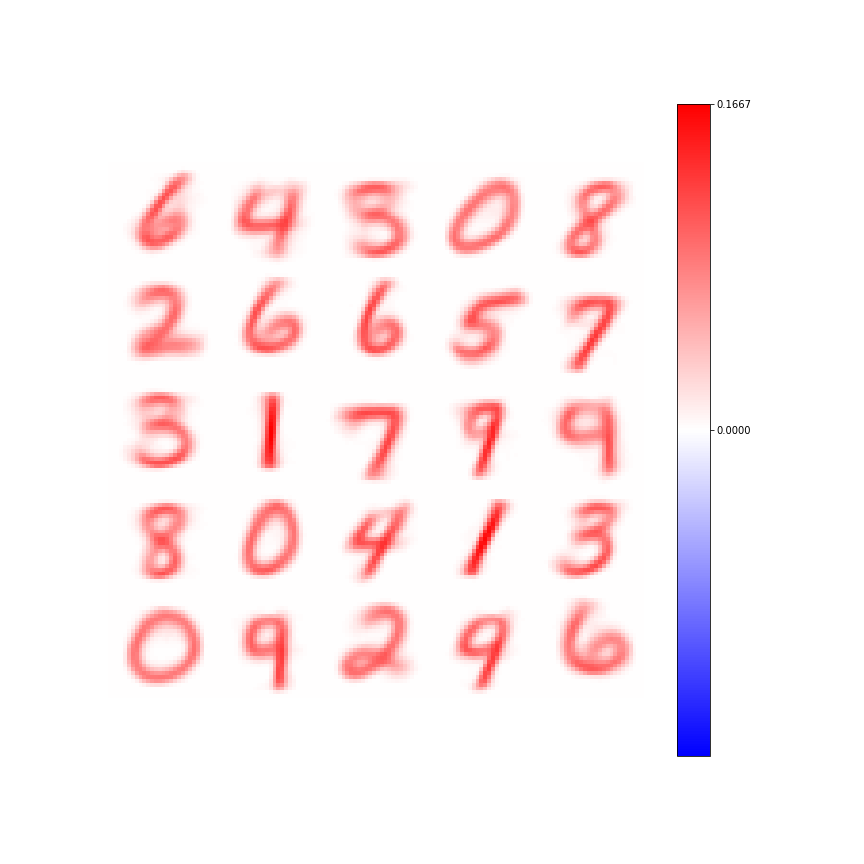

100%|██████████████████████████████████████████████████████████| 60000/60000 [01:30<00:00, 659.54it/s]


In [3]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 5
Ky = 5
xi = 0.001
n = 1

N = Kx * Ky

Nep = 1
B = 400
prec = 1e-30

T_s = 60000


w = np.abs(np.random.uniform(0, 1, (N, L)))

inputs = flat_x

for ep in range(Nep):
    
    for i in tqdm(range(T_s)): 
        v = inputs[i]
        
        o = w @ v.reshape(-1, 1)
        
        m_ao = np.argmax(o)
        m_o = np.max(o)
                
        w[m_ao] += (v - (m_o * w[m_ao])) * xi
        
        if i % 100 == 0:
            draw_weights(w, Kx, Ky)

OH MY FUCKING GOSH!!  I know I was trying not to say fuck, but FUCK!!! Something I made works!!  I wonder why it's so slow.  I mean, I haven't mini-batched it yet, but wow it's slow.  I'm going to try to see if I can speed it up.  

<IPython.core.display.Javascript object>


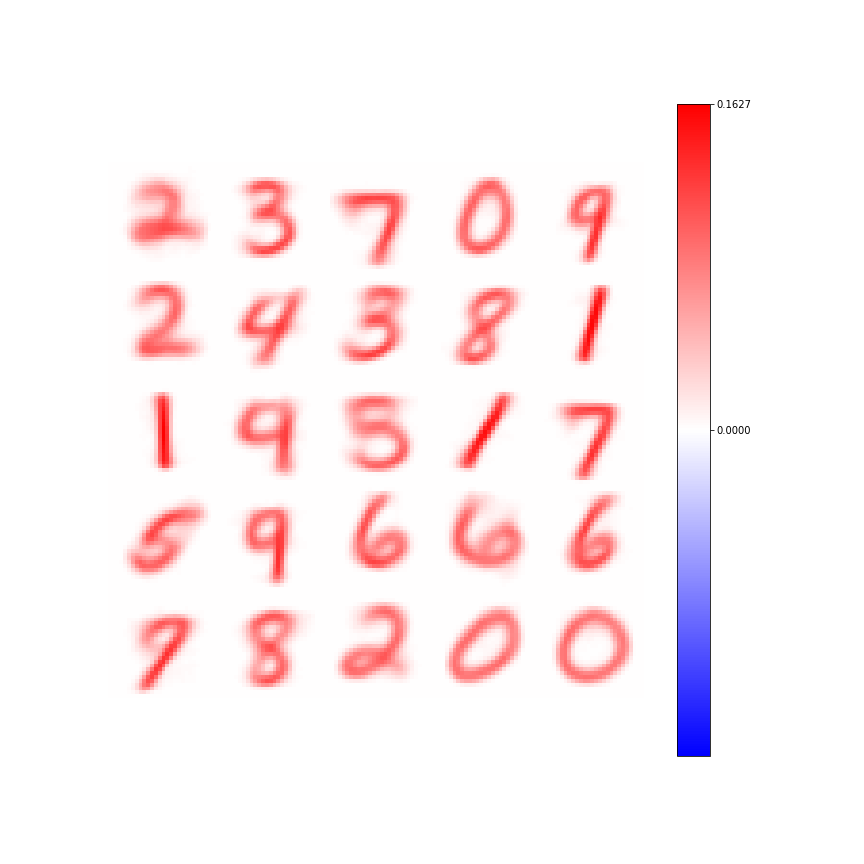

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:07<00:00, 8542.52it/s]


In [5]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 5
Ky = 5
xi = 0.001
n = 1

N = Kx * Ky

Nep = 1
B = 400
prec = 1e-30

T_s = 60000


w = np.abs(np.random.uniform(0, 1, (N, L)))

inputs = flat_x

for ep in range(Nep):
    
    for i in tqdm(range(T_s)): 
        v = inputs[i]
        
        o = w @ v.reshape(-1, 1)
        
        m_ao = np.argmax(o)
        m_o = np.max(o)
                
        w[m_ao] += (v - (m_o * w[m_ao])) * xi
        
        if i % 5000 == 0:
            draw_weights(w, Kx, Ky)

Oh, it was just cause I was drawing the weights so frequently.  Now it's back down in the correct ballpark.  

OH MY GOSH!!!!!!!!!


OH MY GOOOOOOOOOSSSSSSSSHHHHHHHHH!!!!!!!!!!

Let's do 100 hehe.

<IPython.core.display.Javascript object>


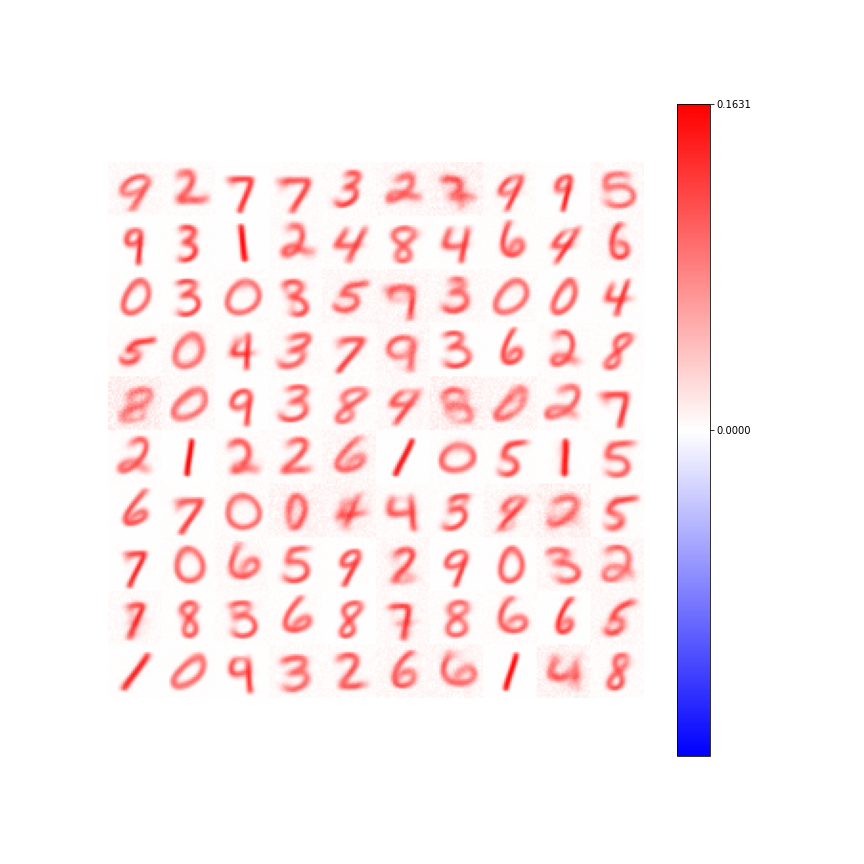

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:10<00:00, 5908.64it/s]


In [8]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.001
n = 1

N = Kx * Ky

Nep = 1
B = 400
prec = 1e-30

T_s = 60000


w = np.abs(np.random.uniform(0, 1, (N, L)))

inputs = flat_x

for ep in range(Nep):
    
    for i in tqdm(range(T_s)): 
        v = inputs[i]
        
        o = w @ v.reshape(-1, 1)
        
        m_ao = np.argmax(o)
        m_o = np.max(o)
                
        w[m_ao] += (v - (m_o * w[m_ao])) * xi
        
        if i % 5000 == 0:
            draw_weights(w, Kx, Ky)

OH MY GOSH!!! I gotta figure out how to batch this.  

<IPython.core.display.Javascript object>


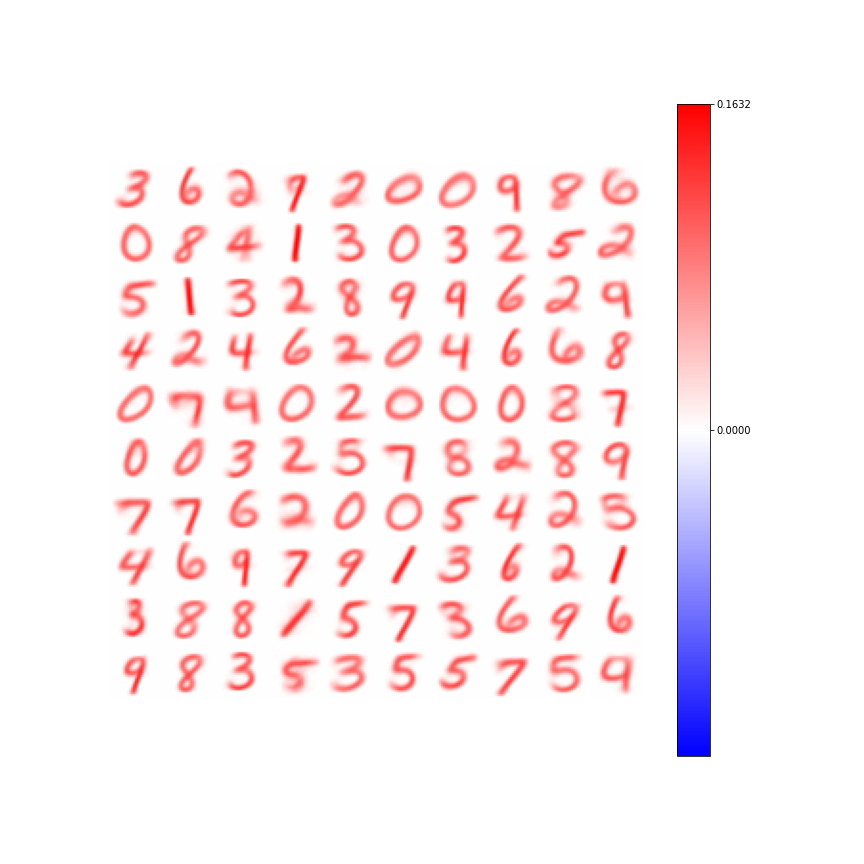

100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 914.53it/s]


In [16]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.001

N = Kx * Ky

Nep = 3
B = 100

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

inputs = flat_x

for ep in range(Nep):
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

Ok, I'm actually in love with this algo.  Those are the prototypes after 3 epochs.  3 EPOCHS!!!!!  No fancy specialization or anything!!!

Let's do 400!!

<IPython.core.display.Javascript object>


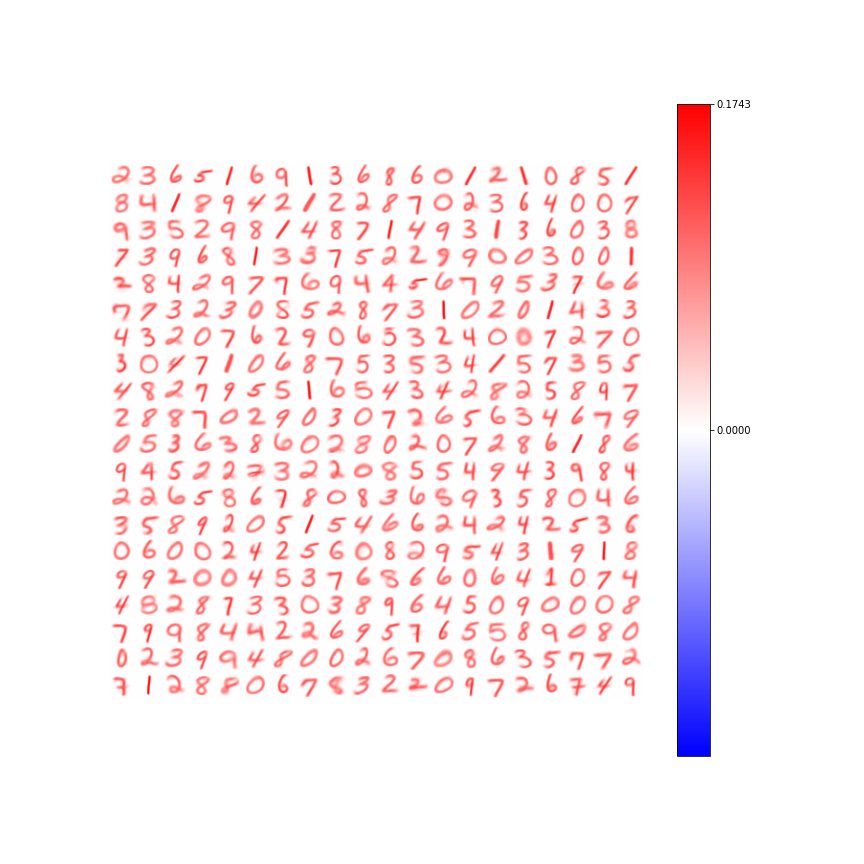

100%|███████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 81.18it/s]


In [26]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.005

N = Kx * Ky

Nep = 10
B = 400

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

The crazy thing is that these prototypes are incredibly stable.  They're literally sculptures being carved from marble.  

You know I gotta try 1,600.  Also, I'm going to pull in wta real quick.

In [49]:
def wta_classification(w, T_s):
    flat_x = np.reshape(train_X, [-1, L])
    flat_test = np.reshape(test_X, [-1, L])
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w[:, :L] @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w[:, :L] @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [28]:
wta_classification(w, T_s)

Neuron classes: [2 3 6 5 1 6 9 1 3 6 8 6 0 1 2 1 0 8 5 1 8 4 1 8 9 4 2 1 2 2 8 7 0 2 3 6 4
 0 0 7 9 3 5 2 9 8 1 4 8 7 1 4 9 3 1 3 6 0 3 8 7 3 9 6 8 1 3 3 7 5 2 2 9 9
 0 0 3 0 0 1 2 8 4 2 9 7 7 6 9 4 4 5 6 7 9 5 3 7 6 6 7 7 3 2 3 0 5 5 2 8 7
 3 1 0 2 0 1 4 3 3 4 3 2 0 7 6 2 9 0 6 3 3 2 4 0 0 7 2 7 0 3 0 4 7 1 0 6 8
 7 5 3 5 3 4 1 5 7 3 5 5 4 8 2 7 9 5 5 1 6 5 4 3 4 2 8 2 5 8 9 7 2 8 8 7 0
 2 9 0 3 0 7 2 6 5 6 3 4 6 7 9 0 5 3 6 3 8 6 0 2 8 0 2 0 7 2 8 6 1 8 6 9 4
 5 2 2 2 3 2 2 0 8 5 5 4 9 4 3 9 8 4 2 2 6 5 8 6 7 8 0 8 3 6 8 9 3 5 8 0 4
 6 3 5 8 9 2 0 5 1 5 4 6 6 2 4 2 4 2 5 3 6 0 6 0 0 2 4 2 5 6 0 8 2 9 5 4 3
 1 9 1 8 9 9 2 0 0 4 5 3 7 6 8 6 6 0 6 4 1 0 7 4 4 8 2 8 7 3 3 0 3 8 9 6 4
 5 0 9 0 0 0 8 7 9 9 8 4 4 2 2 6 9 5 7 6 5 5 8 9 0 8 0 0 2 3 9 9 4 8 0 0 2
 6 7 0 8 6 3 5 7 7 2 7 1 2 8 8 0 6 7 8 3 2 2 0 9 7 2 6 7 4 9]
Accuracy: 94.09%
Misclassifieds:  [ 13.   9.  44.  69. 107.  90.  20.  80.  75.  84.]


Woah.  Holy cow.  Have I ever gotten that high with CompSpec??

I need to try 100 neurons.

<IPython.core.display.Javascript object>


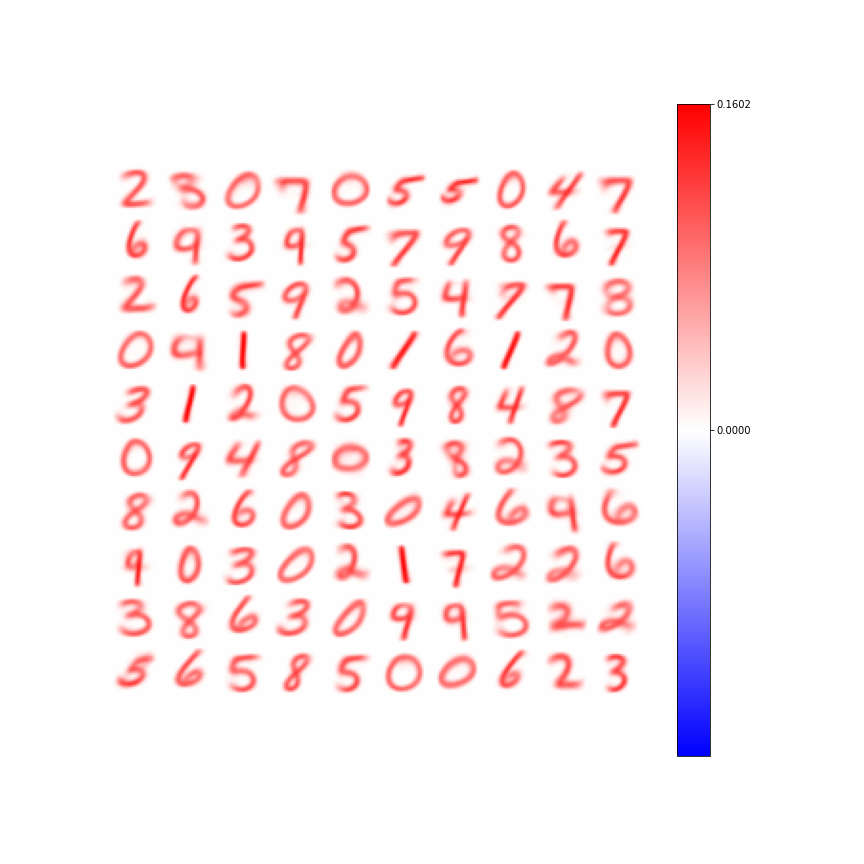

100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 884.79it/s]


Neuron classes: [2 3 0 7 0 5 5 0 4 7 6 9 3 9 5 7 9 8 6 7 2 6 5 9 2 5 4 7 7 8 0 4 1 8 0 1 6
 1 2 0 3 1 2 0 5 9 8 4 8 7 0 9 4 8 0 3 8 2 3 5 8 2 6 0 3 0 4 6 4 6 9 0 3 0
 2 1 7 2 2 6 3 8 6 3 0 9 9 5 2 2 5 6 5 8 5 0 0 6 2 3]
Accuracy: 88.76%
Misclassifieds:  [ 16.  19.  71. 138. 357.  98.  33. 132. 116. 144.]


In [31]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.001

N = Kx * Ky

Nep = 10
B = 100

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))


for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)
    
wta_classification(w, T_s)

Yuuup, that's about hitting the upper limit of 100 neurons.  

Ok, 1,600!

<IPython.core.display.Javascript object>


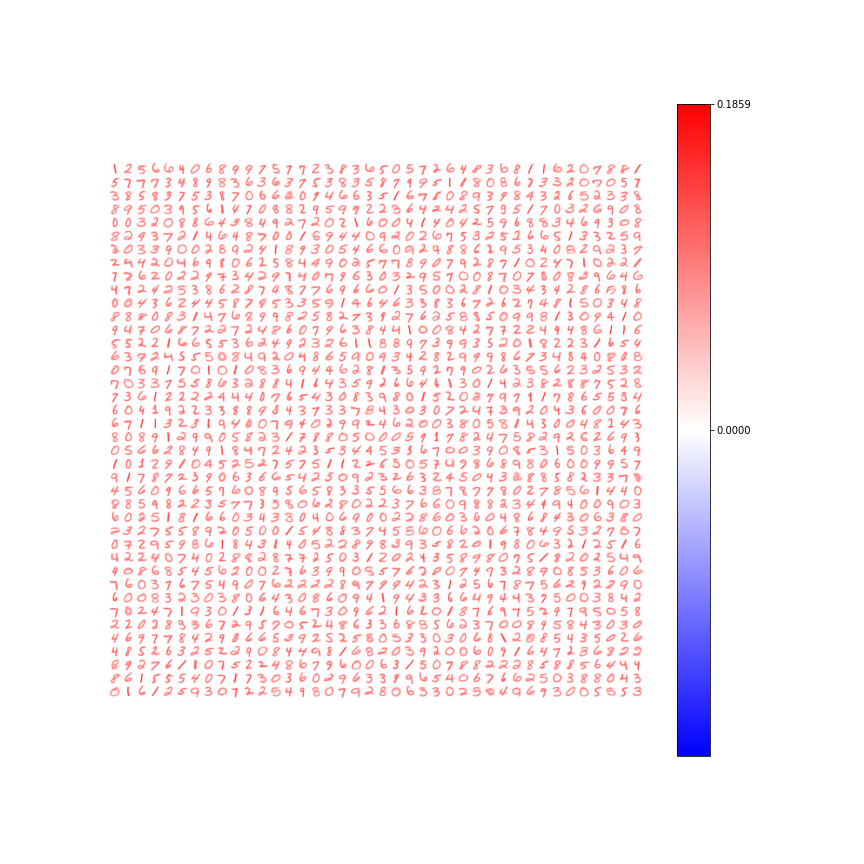

100%|███████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


Neuron classes: [1 2 5 ... 5 5 3]
Accuracy: 95.69%
Misclassifieds:  [10.  7. 29. 53. 61. 59. 15. 73. 59. 65.]


In [34]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 40
Ky = 40
xi = 0.008

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Well, that is simply magnificent.  My gosh I'm incredibly happy.  And, if I want neurons to win more frequently, I just increase all its weights.  That is incredibly fantastic.  

Oh my gracious goodness I'm happy!  Finally!  Something of my own design works!

<IPython.core.display.Javascript object>


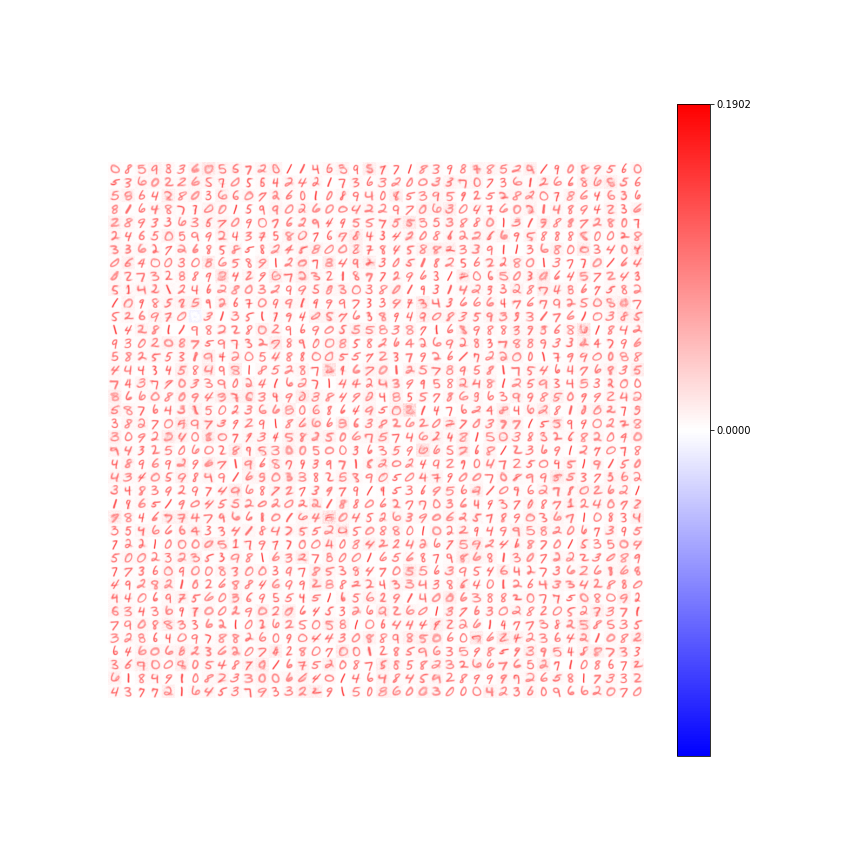

100%|███████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.45it/s]


Neuron classes: [0 8 5 ... 0 7 0]
Accuracy: 95.08%
Misclassifieds:  [11. 15. 42. 55. 87. 55. 17. 66. 62. 82.]


In [39]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 40
Ky = 40
xi = 0.008

N = Kx * Ky

Nep = 2
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Wait.  Hold the phone.  This is literally the exact same thing as KH's network.  Lol, and I thought I had created something that works.  Anyway, now I have an inkling about backward reconstruction.  And I know how to make this network do what I want.  Wow, that's absolutely wild that I literally just reconstructed KH's algorithm, and thought it was my own.  Holy cow.  But at the very least, I know the initialization scheme should be a bunch of high numbers.  That's the secret.  Wow.  

I still can't believe that.  I'm really lost in the sauce right now. Time for lunch.

Ok, we're trying something new now. I'm including the classification in the input vector.

<IPython.core.display.Javascript object>


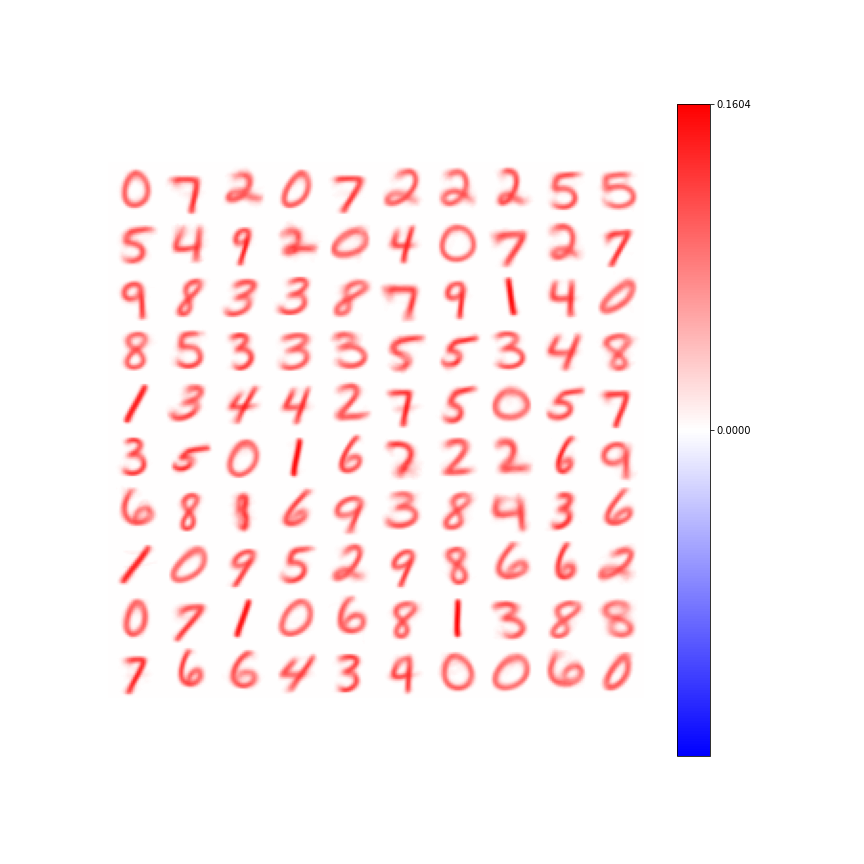

(60000, 794)


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 403.76it/s]


Neuron classes: [0 7 2 0 7 2 2 2 5 5 5 4 9 2 0 4 0 7 2 7 9 8 3 3 8 7 9 1 4 0 8 5 3 3 3 5 5
 3 4 8 1 3 4 4 2 7 5 0 5 7 3 5 0 1 6 7 2 2 6 9 6 8 1 6 9 3 8 4 3 6 1 0 9 5
 2 9 8 6 6 2 0 7 1 0 6 8 1 3 8 8 7 6 6 4 3 4 0 0 6 0]
Accuracy: 90.13%
Misclassifieds:  [ 15.  14. 105.  93. 171. 127.  40. 114. 117. 191.]


In [64]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.008

N = Kx * Ky

Nep = 2
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

<IPython.core.display.Javascript object>


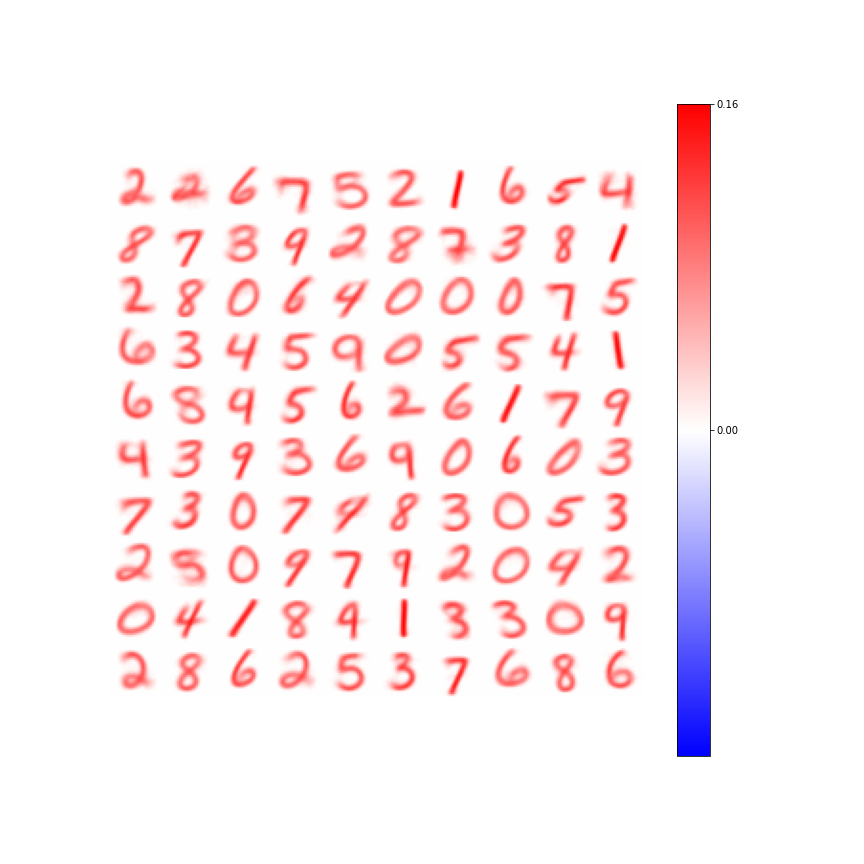

100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 416.33it/s]


Neuron classes: [2 2 6 7 5 2 1 6 5 4 8 7 8 9 2 8 7 3 8 1 2 8 0 6 4 0 0 0 7 5 6 3 4 5 9 0 5
 5 4 1 6 8 4 5 6 2 6 1 7 9 4 3 9 3 6 9 0 6 0 3 7 3 0 7 4 8 3 0 5 3 2 5 0 9
 7 9 2 0 4 2 0 4 1 8 4 1 3 3 0 9 2 8 6 2 5 3 7 6 8 6]
Accuracy: 87.48%
Misclassifieds:  [ 19.  17. 105. 120. 236. 128.  26. 184. 125. 292.]


In [62]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 10
Ky = 10
xi = 0.008

N = Kx * Ky

Nep = 2
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

OOOOOOOOOOOOOHHHHHHHHHHHHH.  The network with the classifications built in is performing around 90% accuracy on average!!!  The one without the classifications built in is doing about 88% on average.  Leeeet's do 400!!

<IPython.core.display.Javascript object>


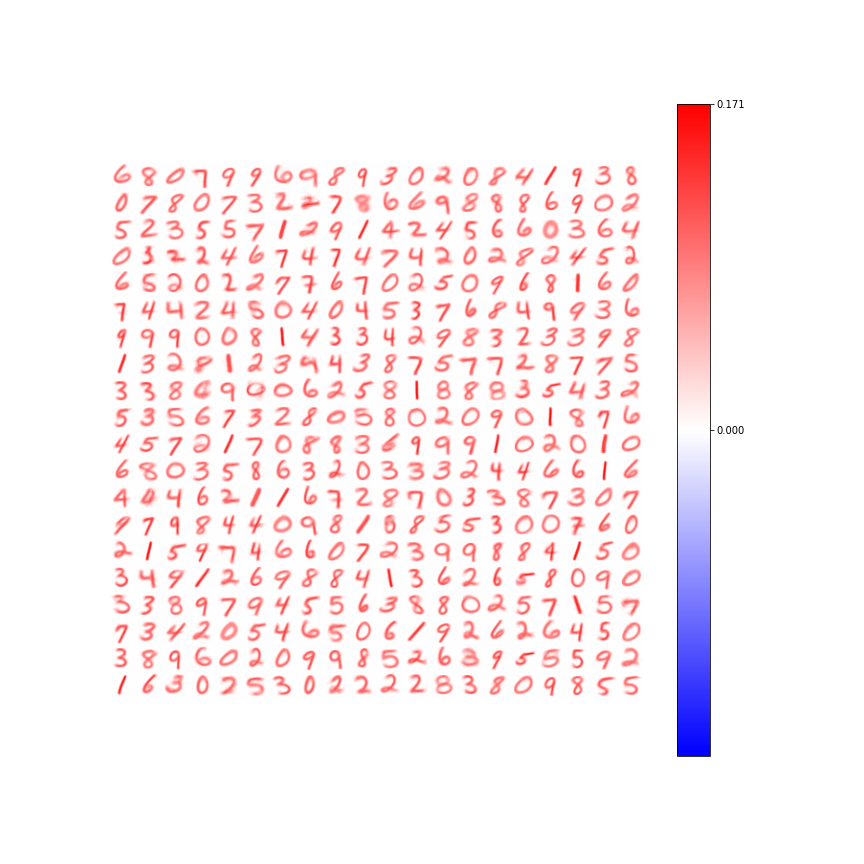

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 69.43it/s]


Neuron classes: [6 8 0 7 9 9 6 9 8 9 3 0 2 0 8 4 1 9 3 8 0 7 8 0 7 3 2 2 7 8 6 6 9 8 8 8 6
 9 0 2 5 2 3 5 5 7 1 2 9 1 4 2 4 5 6 6 0 3 6 4 0 1 2 2 4 6 7 4 7 4 7 4 2 0
 2 8 2 4 5 2 6 5 2 0 2 2 7 7 6 7 0 2 5 0 9 6 8 1 6 0 7 4 4 2 4 8 0 4 0 4 5
 3 7 6 8 4 9 9 3 6 9 9 9 0 0 8 1 4 3 3 4 2 9 8 3 2 3 3 9 8 1 3 2 8 1 2 3 4
 4 3 8 7 5 7 7 2 8 7 7 5 3 3 8 6 9 6 0 6 2 5 8 1 8 8 8 3 5 4 3 2 5 3 5 6 7
 3 2 8 0 5 8 0 2 0 9 0 1 8 7 6 4 5 7 2 1 7 0 8 8 3 6 9 9 9 1 0 2 0 1 0 6 8
 0 3 5 8 6 3 2 0 3 3 3 2 4 4 6 6 1 6 4 4 4 6 2 1 1 6 7 2 8 7 0 3 3 8 7 3 0
 7 9 7 9 8 4 4 0 9 8 1 0 8 5 5 3 0 0 7 6 0 2 1 5 4 7 4 6 6 0 7 2 3 9 9 8 8
 4 1 5 0 3 4 9 1 2 6 9 8 8 4 1 3 6 2 6 5 8 0 9 0 3 3 8 9 7 9 4 5 5 6 3 8 8
 0 2 5 7 1 5 7 7 3 4 2 0 5 4 6 5 0 6 1 9 2 6 2 6 4 5 0 3 8 9 6 0 2 0 9 9 8
 5 2 6 3 9 5 5 5 9 2 1 6 3 0 2 5 3 0 2 2 2 2 8 3 8 0 9 8 5 5]
Accuracy: 94.16%
Misclassifieds:  [ 14.   8.  40.  74. 108.  83.  25.  85.  58.  89.]


In [75]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.008

N = Kx * Ky

Nep = 2
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

<IPython.core.display.Javascript object>


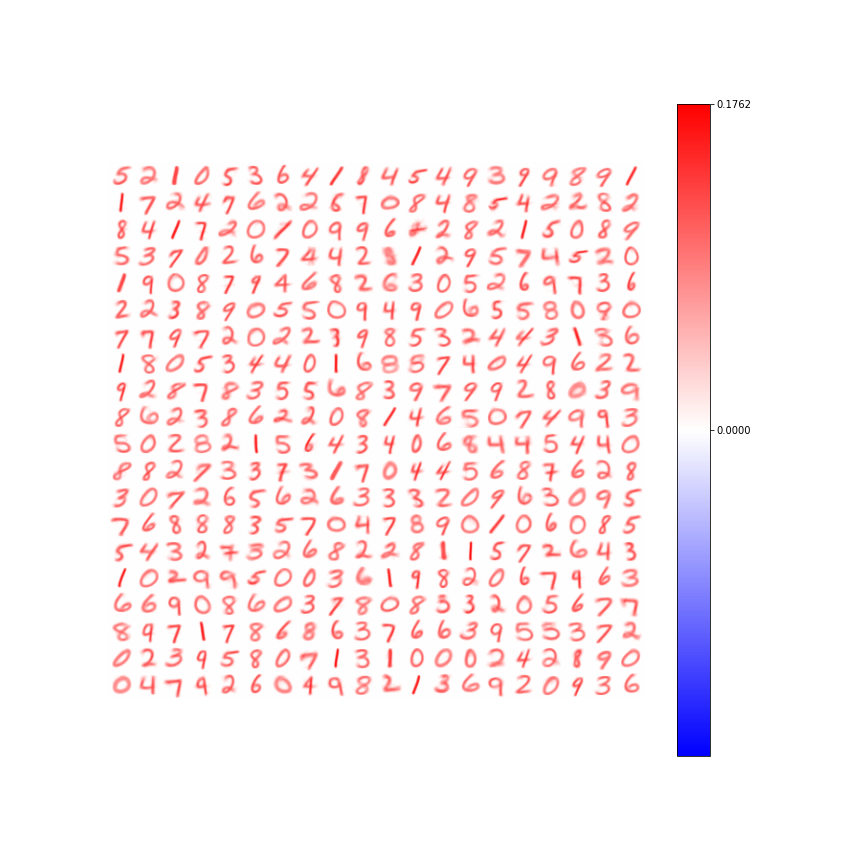

100%|███████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 70.36it/s]


Neuron classes: [5 2 1 0 5 3 6 4 1 8 4 5 4 9 3 9 9 8 9 1 1 7 2 4 7 6 2 2 6 7 0 8 4 8 5 4 2
 2 8 2 8 4 1 7 2 0 1 0 9 9 6 2 2 8 2 1 5 0 8 9 5 3 7 0 2 6 7 4 4 2 8 1 2 9
 5 7 4 5 2 0 1 9 0 8 7 9 4 6 8 2 6 3 0 5 2 6 9 7 3 6 2 2 3 8 9 0 5 5 0 9 4
 9 0 6 5 5 8 0 9 0 7 7 9 7 2 0 2 2 3 9 8 5 3 2 4 4 3 1 3 6 1 8 0 5 3 4 4 0
 1 6 8 5 7 4 0 4 9 6 2 2 9 2 8 7 8 3 5 5 6 8 3 9 7 9 9 2 8 0 3 9 8 6 2 3 8
 6 2 2 0 8 1 4 6 5 0 7 4 9 9 3 5 0 2 8 2 1 5 6 4 3 4 0 6 8 4 4 5 4 4 0 8 8
 2 7 3 3 7 3 1 7 0 4 4 5 6 8 7 6 2 8 3 0 7 2 6 5 6 2 6 3 3 3 2 0 9 6 3 0 9
 5 7 6 8 8 8 3 5 7 0 4 7 8 9 0 1 0 6 0 8 5 5 4 3 2 7 3 2 6 8 2 2 8 1 1 5 7
 2 6 4 3 1 0 2 9 9 5 0 0 3 6 1 9 8 2 0 6 7 4 6 3 6 6 9 0 8 6 0 3 7 8 0 8 3
 3 2 0 5 6 7 7 8 9 7 1 7 8 6 8 6 3 7 6 6 3 9 5 5 3 7 2 0 2 3 9 5 8 0 7 1 3
 1 0 0 0 2 4 2 8 9 0 0 4 7 4 2 6 0 4 9 8 2 1 3 6 9 2 0 9 3 6]
Accuracy: 93.37%
Misclassifieds:  [ 13.  15.  50.  74. 125.  95.  22.  93.  80.  96.]


In [73]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.008

N = Kx * Ky

Nep = 2
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Once again, the network with the classifications built in is on average doing better!  That's dope.  I'm going to try to push it a bit. 

<IPython.core.display.Javascript object>


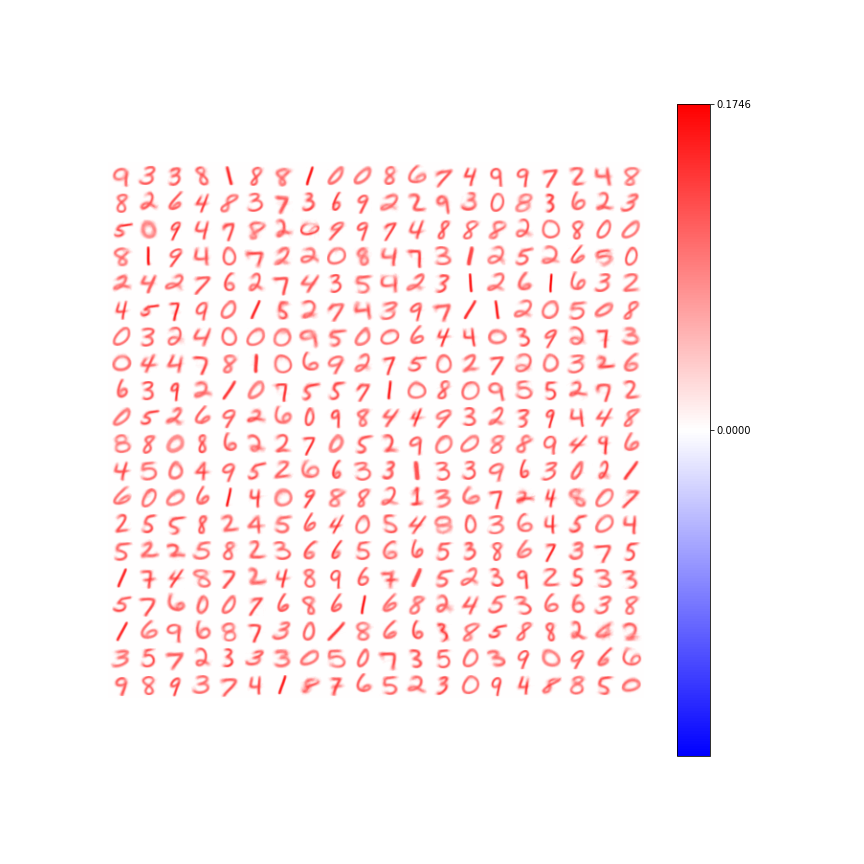

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 70.16it/s]


Neuron classes: [9 3 3 8 1 8 8 1 0 0 8 6 7 4 9 9 7 2 4 8 8 2 6 4 8 3 7 3 6 9 2 2 9 3 0 8 3
 6 2 3 5 0 9 4 7 8 2 6 9 9 7 4 8 8 8 2 0 8 0 0 8 1 9 4 0 7 2 2 0 8 4 7 3 1
 2 5 2 6 5 0 2 4 2 7 6 2 7 4 3 5 4 2 3 1 2 6 1 6 3 2 4 5 7 9 0 1 5 2 7 4 3
 9 7 1 1 2 0 5 0 8 0 3 2 4 0 0 0 9 5 0 0 6 4 4 0 3 9 2 7 3 0 4 4 7 8 1 0 6
 9 2 7 5 0 2 7 2 0 3 2 6 6 3 9 2 1 0 7 5 5 7 1 0 8 0 9 5 5 2 7 2 0 5 2 6 9
 2 6 0 9 8 4 4 9 3 2 3 9 4 4 8 8 8 0 8 6 2 2 7 0 5 2 9 0 0 8 8 9 4 4 6 4 5
 0 4 9 5 2 6 6 3 3 1 3 3 9 6 3 0 2 1 6 0 0 6 1 4 0 9 8 8 2 1 3 6 7 2 4 8 0
 7 2 5 5 8 2 4 5 6 4 0 5 4 8 0 3 6 4 5 0 4 5 2 2 5 8 2 3 6 6 5 6 6 5 3 8 6
 7 3 7 5 1 7 4 8 7 2 4 8 9 6 7 1 5 2 3 9 2 5 3 3 5 7 6 0 0 7 6 8 6 1 6 8 2
 4 5 3 6 6 3 8 1 6 9 6 8 7 3 0 1 8 6 6 3 8 5 8 8 2 4 2 3 5 7 2 3 3 3 0 5 0
 7 3 5 0 3 9 0 9 6 6 9 8 9 3 7 4 1 8 7 6 5 2 3 0 9 4 8 8 5 0]
Accuracy: 94.73%
Misclassifieds:  [ 11.  11.  46.  64.  77.  64.  22.  77.  49. 106.]


In [84]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.005

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

<IPython.core.display.Javascript object>


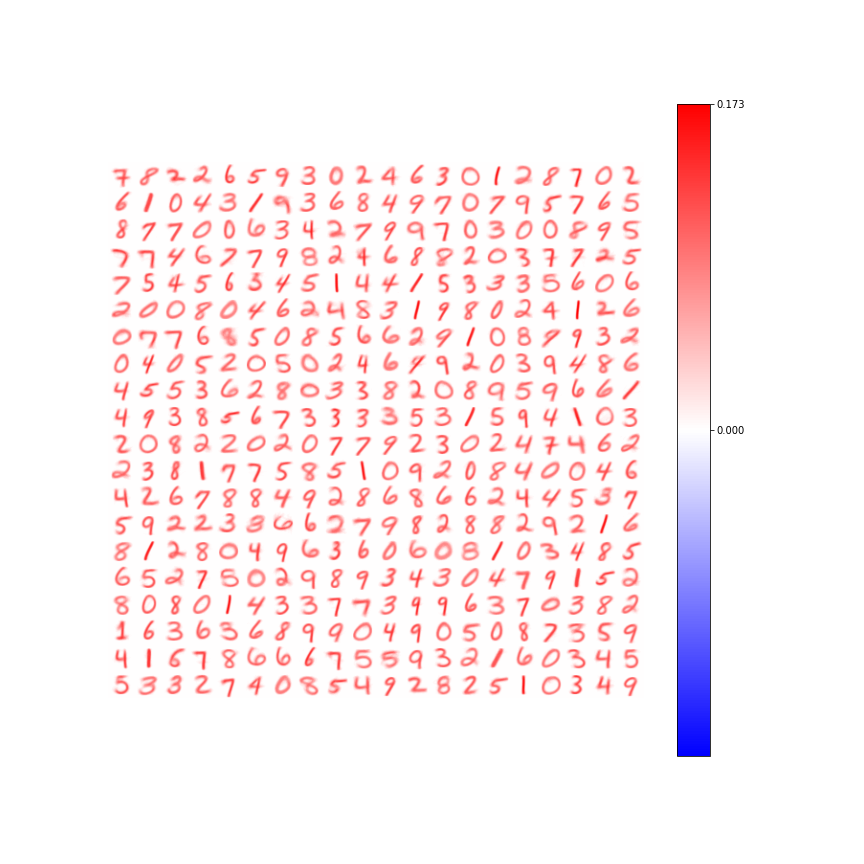

100%|███████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 70.08it/s]


Neuron classes: [7 8 2 2 6 5 9 3 0 2 4 6 3 0 1 2 8 7 0 2 6 1 0 4 3 1 9 3 6 8 4 9 7 0 7 9 5
 7 6 5 8 7 7 0 0 6 3 4 2 7 9 9 7 0 3 0 0 8 9 5 7 7 4 6 7 7 9 8 2 4 6 8 8 2
 0 3 7 7 2 5 7 5 4 5 6 3 4 5 1 4 4 1 5 3 3 3 5 6 0 6 2 0 0 8 0 4 6 2 4 8 3
 1 9 8 0 2 4 1 2 6 0 7 7 6 8 5 0 8 5 6 6 2 9 1 0 8 7 9 3 2 0 4 0 5 2 0 5 0
 2 4 6 4 9 2 0 3 9 4 8 6 4 5 5 3 6 2 8 0 3 3 8 2 0 8 9 5 9 6 6 1 4 9 3 8 5
 6 7 3 3 3 3 5 3 1 5 9 4 1 0 3 2 0 8 2 2 0 2 0 7 7 9 2 3 0 2 4 7 4 6 2 2 3
 8 1 7 7 5 8 5 1 0 9 2 0 8 4 0 0 4 6 4 2 6 7 8 8 4 9 2 8 6 8 6 6 2 4 4 5 3
 7 5 9 2 2 3 3 6 6 2 7 9 8 2 8 8 2 9 2 1 6 8 1 2 8 0 4 9 6 3 6 0 6 0 8 1 0
 3 4 8 5 6 5 2 7 5 0 2 9 8 9 3 4 3 0 4 7 9 1 5 2 8 0 8 0 1 4 3 3 7 7 3 9 9
 6 3 7 0 3 8 2 1 6 3 6 3 6 8 9 9 0 4 9 0 5 0 8 7 3 5 9 4 1 6 7 8 6 6 6 7 5
 5 9 3 2 1 6 0 3 4 5 5 3 3 2 7 4 0 8 5 4 9 2 8 2 5 1 0 3 4 9]
Accuracy: 94.13%
Misclassifieds:  [10.  9. 51. 68. 98. 92. 21. 83. 71. 84.]


In [83]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 20
Ky = 20
xi = 0.005

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Yup.  The one with classifications built in is doing about 0.3% better.  Let's go to town on 1,600 neurons.

<IPython.core.display.Javascript object>


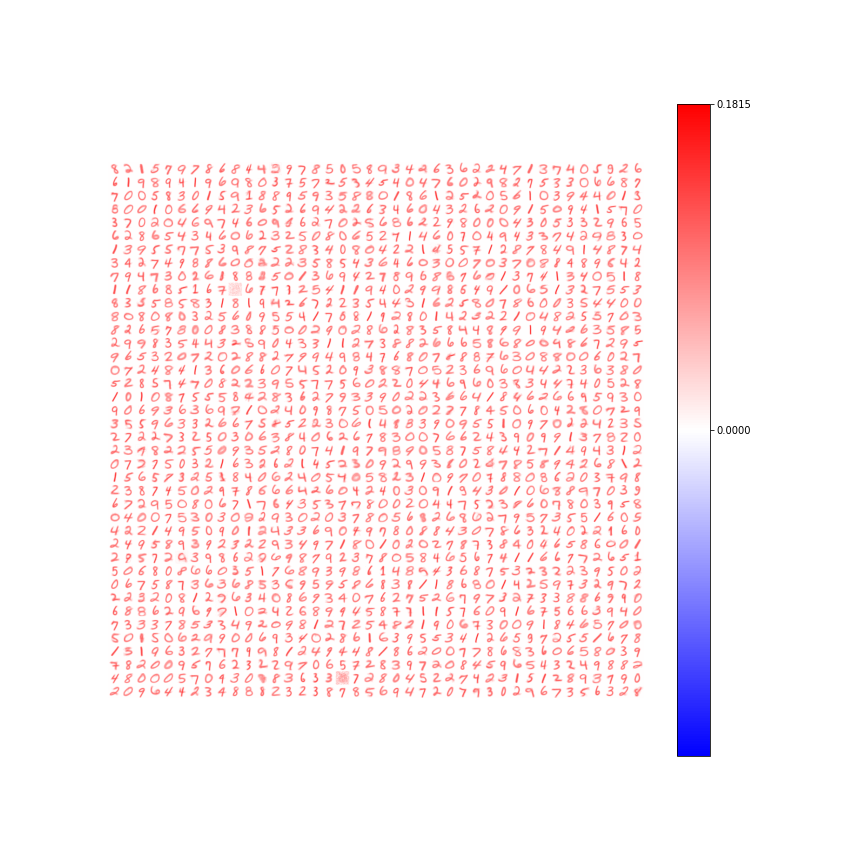

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.16it/s]


Neuron classes: [8 2 1 ... 3 2 8]
Accuracy: 95.67%
Misclassifieds:  [ 5.  7. 37. 67. 66. 51. 22. 68. 50. 60.]


In [88]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 40
Ky = 40
xi = 0.008

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

<IPython.core.display.Javascript object>


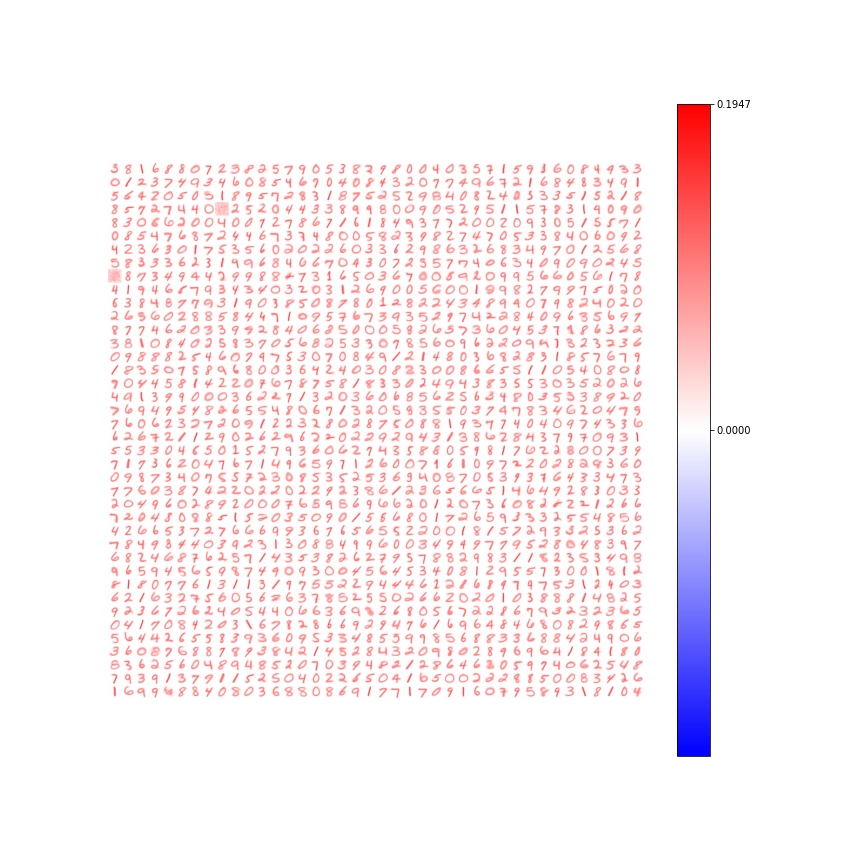

100%|███████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.31it/s]


Neuron classes: [3 8 1 ... 1 0 4]
Accuracy: 95.68%
Misclassifieds:  [12.  9. 31. 57. 60. 52. 11. 68. 51. 81.]


In [92]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 40
Ky = 40
xi = 0.008

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Dope!  On average, there's a 0.3% difference between the one with classifications baked in, and the one that doesn't. Gonna just try 6,400 neurons, see what we get

<IPython.core.display.Javascript object>


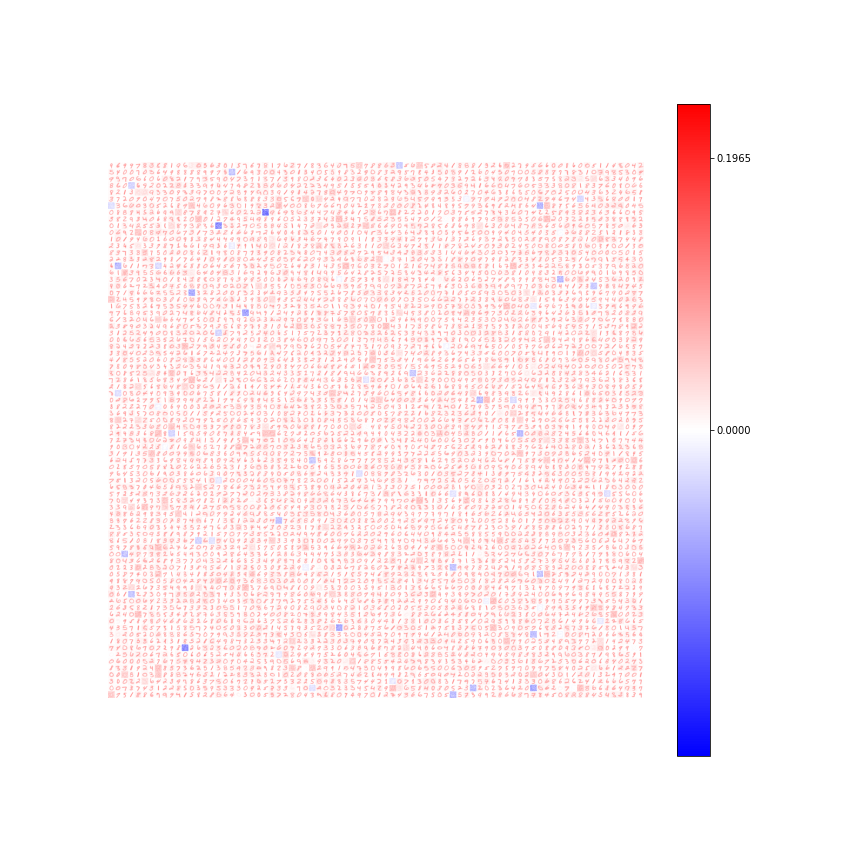

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:31<00:00,  3.69it/s]


Neuron classes: [9 6 9 ... 8 3 9]
Accuracy: 96.67%
Misclassifieds:  [ 6.  3. 32. 47. 42. 42. 13. 42. 50. 56.]


In [93]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 80
Ky = 80
xi = 0.01

N = Kx * Ky

Nep = 5
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

Dang.  Just brimming on 97%.  I'm going to lower xi, run it ten epochs, and see what we can get.

<IPython.core.display.Javascript object>


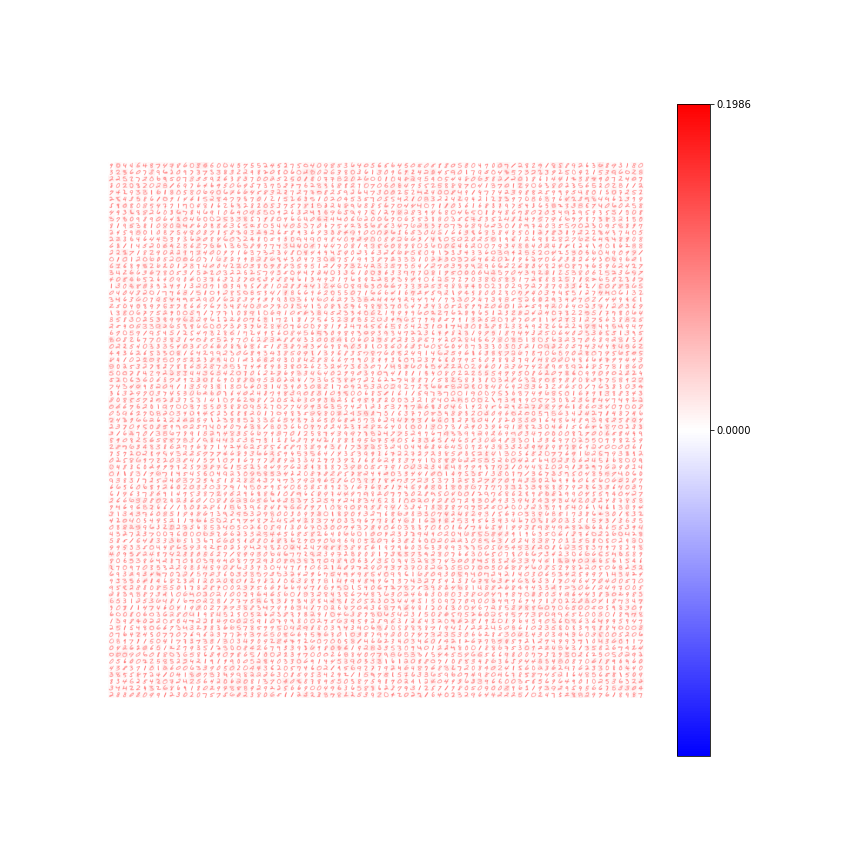

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:30<00:00,  3.87it/s]


Neuron classes: [9 0 4 ... 9 8 7]
Accuracy: 96.53%
Misclassifieds:  [ 8.  5. 35. 34. 47. 38. 13. 47. 62. 58.]


In [94]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 80
Ky = 80
xi = 0.005

N = Kx * Ky

Nep = 10
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

...i think I can do better.  Time for 20 epochs.

<IPython.core.display.Javascript object>


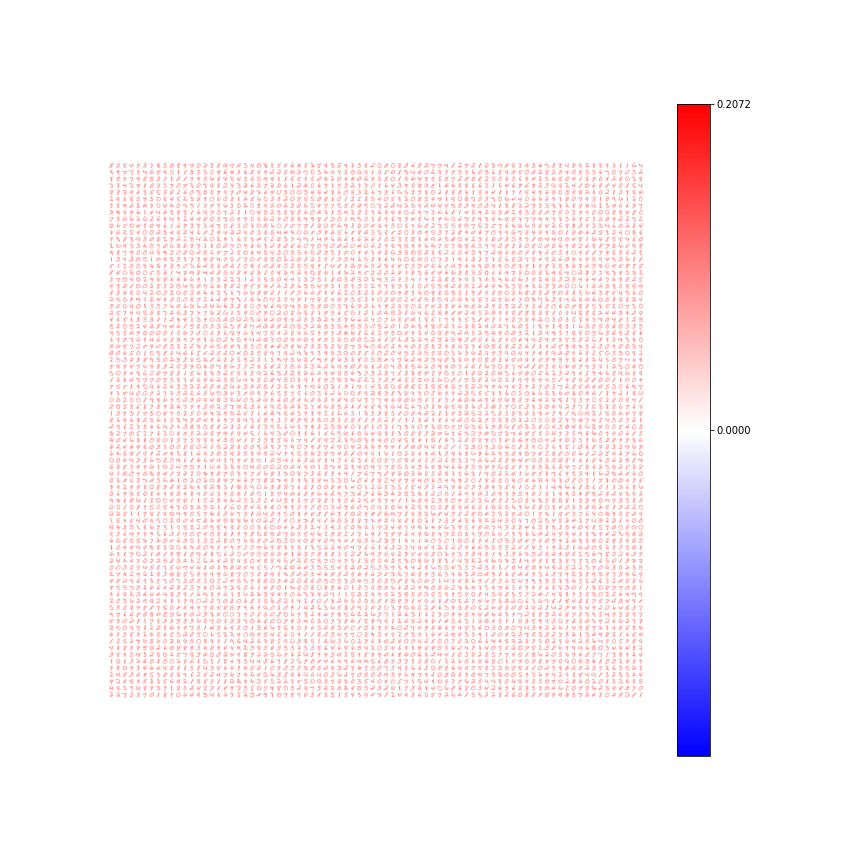

(60000, 794)


100%|███████████████████████████████████████████████████████████████| 120/120 [00:31<00:00,  3.83it/s]


Neuron classes: [8 0 5 ... 2 1 1]
Accuracy: 96.69%
Misclassifieds:  [ 8.  7. 28. 46. 48. 38. 11. 45. 49. 51.]


In [95]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 80
Ky = 80
xi = 0.005

N = Kx * Ky

Nep = 20
B = 500

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, L + 10)))

clsfn_mask = np.zeros((S, 10))
clsfn_mask[np.arange(S), train_y] = 1

flat_in = np.concatenate((flat_x, clsfn_mask), axis=1)
print(flat_in.shape)

for ep in range(Nep):
    inputs = flat_in[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights(w, Kx, Ky)

wta_classification(w, T_s)

I'm guessing that's about as good as we can do with this setup.  Still, that's pretty darn good.

Ok, I think I'm going to conclude this experiment now.

## Conclusions

The result of this experiment is that I basically developed an intuition that led me right back to Krotov and Hopfield's network.  The key is to train the the post-synaptic neurons to be able to predict the values of the pre-synaptic neurons.  It's a constant flow of back and forth.  

My intuition tells me that if the measure of the pre-synaptic neuron is low, it should take on the value predicted for it by the post-synaptic neurons.  This would allow the network to "fill in the blanks" of missing information, if certain pieces of information aren't present.  

Also, awesomely enough, I can use this methodology to predict classifications, even with a single layer.  When I feed in the classifications with the input vector, the network has a better wta classification accuracy.  I think this is because the network is also trying to predict the classifications with the input vectors, so the prototypes it learns are in better correspondence with the actual prototypes for those particular classifications.  

This is also pretty awesome because even if the network doesn't have inputs, it can still train as if it did, because the inputs are "filled in" by the predictions.  So the network is essentially always training.  

If this is how the brain works, then it totally makes sense.  Also this might be how we dream.  If you withhold information from the eyes (sight), then eventually the network will begin backfilling information, all the way to the optical neurons.  Then those will be activated, and you will essentially be seeing visions.  When you wake up, you start receiving information from you optical neurons, and everything is flipped again, and you keep learning.  

So sleep (or general sensory deprivation) could potentially be a good time to solidify the representations held in the neurons while the brain isn't receiving external input.  

That's something. Dang.

## Next steps

I'm actually pretty tired, so I think I'm going to stop work for the night.  This was a weird day.  I kinda thought I was going crazy for part of it.  I was getting super lost in the sauce with trying to figure out Hebbian-style learning strategies.  But this is just super dope.  

What are the next steps?  As always, I need to take apart the image into constituent parts.  But there's also work to be done at this stage as well.  I need to mess with the reconstruction weights in this first layer, and see what I can get.  I'm writing what this means on my white board so I don't forget it, but I just don't want to...(put it here).  Whatever.

$$
\Delta w_i = v_i - \frac{1}{\zeta_i}\left<\vec{w}, \vec{v}\right> w_i
$$

The reconstruction constants I believe give more importance to particular synapses when finding correlations. The bigger they are, the more important the synapse is.  Or so I think.  We'll see.

This was a very very good day and experiment.  